In [1]:
import sys
import os
import yaml
import json
import numpy as np
import random
import subprocess
import torch
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import scipy
import pickle as pkl

sys.path.append('../../embeddings/')
sys.path.append('../../boshnas/')
sys.path.append('../../transformers/src/')

from library import Graph, GraphLib
from utils import embedding_util
from boshnas import BOSHNAS
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from acq import gosh_acq as acq
from transformers import RobertaTokenizer, BertConfig
from transformers.models.bert.modeling_modular_bert import BertModelModular, BertForMaskedLMModular

SAVE_FIGS = True

In [2]:
trained_hashes_bert = os.listdir('/scratch/gpfs/stuli/txf_design-space/models_bert_new/glue/')
trained_hashes_homo = os.listdir('/scratch/gpfs/stuli/txf_design-space/models_homogeneous/glue/')
trained_hashes_1 = os.listdir('/scratch/gpfs/stuli/txf_design-space/models_1/glue/')
trained_hashes_2 = os.listdir('/scratch/gpfs/stuli/txf_design-space/models_2/glue/')
# trained_hashes_3 = os.listdir('/scratch/gpfs/stuli/txf_design-space/models_3/glue/')

trained_hashes = []
trained_hashes.extend(trained_hashes_homo)
trained_hashes.extend(trained_hashes_1)
trained_hashes.extend(trained_hashes_2)
# trained_hashes.extend(trained_hashes_3)
trained_hashes = list(set(trained_hashes))

graphLib_1 = GraphLib.load_from_dataset('../../dataset/dataset_test_bn.json')
graphLib_2 = GraphLib.load_from_dataset('../../dataset/dataset_test_bn_2.json')
graphLib_3 = GraphLib.load_from_dataset('../../dataset/dataset_test_bn_3.json')

def is_homogeneous(graphObject):
    model_dict = graphObject.model_dict
    hashed_f = [hash(str(item)) for item in model_dict['f']]
    return True if len(set(model_dict['h'])) == 1 and len(set(model_dict['n'])) == 1 and len(set(model_dict['o'])) == 1 \
        and len(set(hashed_f)) == 1 and len(set(model_dict['p'])) == 1 else False

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

tokenizer = RobertaTokenizer.from_pretrained('../../roberta_tokenizer/')
config = BertConfig(vocab_size = tokenizer.vocab_size)

model_dict_bert_tiny = {'l':2, 'o':['sa']*2, 'h':[128]*2, 'n':[2]*2, 'f':[[4*128]]*2, 'p':['sdp']*2}
model_dict_bert_mini = {'l':4, 'o':['sa']*4, 'h':[256]*4, 'n':[4]*4, 'f':[[1024]]*4, 'p':['sdp']*4}

homogeneous_models, heterogenous_models = 0, 0
X_ds_total = np.zeros((len(trained_hashes), 16))
y_ds_total = np.zeros((len(trained_hashes)))
X_ds_1 = np.zeros((len(set(trained_hashes_1 + trained_hashes_homo)), 16))
y_ds_1 = np.zeros((len(set(trained_hashes_1 + trained_hashes_homo))))
count = 0
count_1 = 0
homogeneous_indices = []
param_homo, perf_homo, param_hetero, perf_hetero = [], [], [], []
bert_indices = []

for model_hash in trained_hashes:
    if model_hash in trained_hashes_homo:
        model, _ = graphLib_1.get_graph(model_hash=model_hash)
        if model_hash in trained_hashes_bert:
            json_file = open(f'/scratch/gpfs/stuli/txf_design-space/models_bert_new/glue/{model_hash}/all_results.json')
        else:
            json_file = open(f'/scratch/gpfs/stuli/txf_design-space/models_homogeneous/glue/{model_hash}/all_results.json')
    elif model_hash in trained_hashes_1:
        model, _ = graphLib_1.get_graph(model_hash=model_hash)
        json_file = open(f'/scratch/gpfs/stuli/txf_design-space/models_1/glue/{model_hash}/all_results.json')
    elif model_hash in trained_hashes_2:
        model, _ = graphLib_2.get_graph(model_hash=model_hash)
        json_file = open(f'/scratch/gpfs/stuli/txf_design-space/models_2/glue/{model_hash}/all_results.json')
#     elif model_hash in trained_hashes_3:
#         model, _ = graphLib_3.get_graph(model_hash=model_hash)
#         json_file = open(f'/scratch/gpfs/stuli/txf_design-space/models_3/glue/{model_hash}/all_results.json')
    
    X_ds_total[count, :], y_ds_total[count] = model.embedding, 1 - json.load(json_file)['glue_score']
    if model_hash in trained_hashes_1 or model_hash in trained_hashes_homo:
        X_ds_1[count_1, :], y_ds_1[count_1] = X_ds_total[count, :], y_ds_total[count]
        count_1 += 1
    count += 1
    
    config.from_model_dict(model.model_dict)
    bert_model = BertForMaskedLMModular(config)
    
    if is_homogeneous(model):
        homogeneous_models += 1
        homogeneous_indices.append(count_1-1)
        param_homo.append(count_parameters(bert_model)); perf_homo.append(1- y_ds_total[count-1])
        if model.model_dict == model_dict_bert_tiny or model.model_dict == model_dict_bert_mini:
            bert_indices.append(len(param_homo)-1)
        if 1 - y_ds_total[count-1] > 0.41: 
            param_hetero.append(count_parameters(bert_model)); perf_hetero.append(1 - y_ds_total[count-1])
    else:
        heterogenous_models += 1
        param_hetero.append(count_parameters(bert_model)); perf_hetero.append(1 - y_ds_total[count-1])
        
print(f'Homogenous models: {homogeneous_models}\nHeterogenous models: {heterogenous_models}')

Homogenous models: 34
Heterogenous models: 68


In [3]:
graphLib_1_n = GraphLib.load_from_dataset('../../dataset/dataset_test_bn.json')
graphLib_1_n.build_naive_embeddings()

X_ds_1_n = np.zeros((len(set(trained_hashes_1 + trained_hashes_homo)), 21))
count = 0

for model_hash in trained_hashes_1:
    model, _ = graphLib_1_n.get_graph(model_hash=model_hash)
    X_ds_1_n[count, :] = model.embedding

Building embeddings for the Graph library
Embeddings generated, of size: 21


In [4]:
print(f'Best design-space performance: {1 - np.amin(y_ds_total): 0.03f}')

best_model_hash = trained_hashes[np.argmin(y_ds_total)]
if best_model_hash in trained_hashes_1:
    best_model, _ = graphLib_1.get_graph(model_hash=best_model_hash)
elif best_model_hash in trained_hashes_2:
    best_model, _ = graphLib_2.get_graph(model_hash=best_model_hash)
# elif best_model_hash in trained_hashes_3:
#     best_model, _ = graphLib_3.get_graph(model_hash=best_model_hash)

    
print(f'Best model hash: {best_model_hash}')
print(f'Best model dict: {best_model.model_dict}')

print(f'Best model is homogenous: {is_homogeneous(best_model)}')

X_ds_homo, y_ds_homo = np.take(X_ds_1, homogeneous_indices, axis=0), np.take(y_ds_1, homogeneous_indices)
X_ds_homo_n = np.take(X_ds_1_n, homogeneous_indices, axis=0)

print(f'Best performance in space of homogenous models: {1 - np.amin(y_ds_homo): 0.03f}')

Best design-space performance:  0.428
Best model hash: 23f3026b5209a1616b04a1fe57875355e59be58ec9adcd39faf3e0648a533cd9
Best model dict: {'l': 4, 'h': [256, 256, 128, 128], 'n': [2, 2, 4, 4], 'o': ['sa', 'sa', 'l', 'l'], 'f': [[512, 512, 512], [512, 512, 512], [1024], [1024]], 'p': ['sdp', 'sdp', 'dct', 'dct']}
Best model is homogenous: False
Best performance in space of homogenous models:  0.421


In [148]:
graphLib_2.get_graph(model_hash='70d79a6325ce426644aed68b93a6d751bcf4dba5b38ced20024a06604b033da7')[0].model_dict

{'l': 4,
 'h': [256, 256, 256, 256],
 'n': [4, 4, 2, 2],
 'o': ['l', 'l', 'l', 'l'],
 'f': [[1024], [1024], [512, 512, 512], [512, 512, 512]],
 'p': ['dct', 'dct', 'dct', 'dct']}

In [5]:
# Implement baselines

class RandomModel():
    def __init__(self):
        pass

    def get_queries(self, x, k, **kwargs):
        return random.sample(list(range(len(x))), k)
    
    def train(self, *args, **kwargs):
        pass
    
class EvolutionaryModel():
    def __init__(self):
        self.r_cross = 0.95 # cross-over rate
        self.r_mut = 0.1 # mutation rate
        pass
    
    def get_queries(self, x, k, **kwargs):
        children = []
        while len(children) < k:
            for c in self._crossover(self.parents[0], self.parents[1]):
                children.append(self._mutation(c))
        indices = []
        for c in children:
            devs = np.mean(np.abs(c - x), axis=1)
            indices.append(np.argmin(devs))
        return list(set(indices))
    
    def train(self, X, y):
        self.parents = [X[i, :] for i in np.argsort(y)[:2]]
        
    def _crossover(self, p1, p2):
        c1, c2 = p1.copy(), p2.copy()
        if random.random() < self.r_cross:
            pt = random.randint(1, len(p1)-2)
            c1 = np.concatenate((p1[:pt], p2[pt:]))
            c2 = np.concatenate((p2[:pt], p1[pt:]))
        return [c1, c2]
    
    def _mutation(self, c):
        for i in range(len(c)):
            if random.random() < self.r_mut:
                c[i] *= -1
        return c
    
class GaussianBayesModel():
    def __init__(self):
        self.model = GP(n_restarts_optimizer=1)

    def get_queries(self, x, k, **kwargs):
        y_ds, std_ds = self.model.predict(x, return_std=True)
        indices = np.argsort(acq(y_ds, std_ds))
        return indices[:k]
    
    def train(self, X, y):
        self.model.fit(X, y)
        
class BANANAS():
    def __init__(self, input_dim):
        self.model_1 = torch.nn.Sequential(torch.nn.Linear(input_dim, 20), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(20, 1))
        self.model_2 = torch.nn.Sequential(torch.nn.Linear(input_dim, 20), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(20, 1))
        self.model_3 = torch.nn.Sequential(torch.nn.Linear(input_dim, 20), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(20, 1))
        self.loss_fn = torch.nn.MSELoss(reduction='sum')
        self.optimizer_1 = torch.optim.Adam(self.model_1.parameters(), lr=1e-3)
        self.optimizer_2 = torch.optim.Adam(self.model_2.parameters(), lr=1e-3)
        self.optimizer_3 = torch.optim.Adam(self.model_3.parameters(), lr=1e-3)
        self.r_cross = 0.95 # cross-over rate
        self.r_mut = 0.1 # mutation rate

    def get_queries(self, x, k, **kwargs):
        children = []
        while len(children) < k:
            for c in self._crossover(self.parents[0], self.parents[1]):
                children.append(self._mutation(c))
        y_ds_1 = np.squeeze(np.array([torch.detach(self.model_1(torch.Tensor(child))).numpy() for child in children]))
        y_ds_2 = np.squeeze(np.array([torch.detach(self.model_2(torch.Tensor(child))).numpy() for child in children]))
        y_ds_3 = np.squeeze(np.array([torch.detach(self.model_3(torch.Tensor(child))).numpy() for child in children]))
        y_ds = np.mean(np.stack([y_ds_1, y_ds_2, y_ds_3], axis=1), axis=1)
        std_ds = np.var(np.stack([y_ds_1, y_ds_2, y_ds_3], axis=1), axis=1)
        acqs = np.array(acq(y_ds, std_ds))
        children = [children[i] for i in np.argsort(acqs)]
        indices = []
        for c in children:
            devs = np.mean(np.abs(c - x), axis=1)
            indices.append(np.argmin(devs))
        return list(set(indices))[:k]
    
    def train(self, X, y):
        self.parents = [X[i, :] for i in np.argsort(y)[:2]]
        X, y = torch.Tensor(X), torch.Tensor(y)
        for _ in range(5):
            y_pred_1, y_pred_2, y_pred_3 = self.model_1(X), self.model_2(X), self.model_3(X)
            loss_1, loss_2, loss_3 = self.loss_fn(y_pred_1, y), self.loss_fn(y_pred_2, y), self.loss_fn(y_pred_3, y)
            self.optimizer_1.zero_grad(); self.optimizer_2.zero_grad(); self.optimizer_3.zero_grad()
            loss_1.backward(); loss_2.backward(); loss_3.backward()
            self.optimizer_1.step(); self.optimizer_2.step(); self.optimizer_3.step()
        
    def _crossover(self, p1, p2):
        c1, c2 = p1.copy(), p2.copy()
        if random.random() < self.r_cross:
            pt = random.randint(1, len(p1)-2)
            c1 = np.concatenate((p1[:pt], p2[pt:]))
            c2 = np.concatenate((p2[:pt], p1[pt:]))
        return [c1, c2]
    
    def _mutation(self, c):
        for i in range(len(c)):
            if random.random() < self.r_mut:
                c[i] *= -1
        return c
    
class REINFORCEModel():
    def __init__(self, input_dim, num_actions):
        self.num_actions = num_actions
        self.model = torch.nn.Sequential(torch.nn.Linear(input_dim, 20),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(20, num_actions),
                                        torch.nn.Softmax())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def get_queries(self, x, k, **kwargs):
        indices = []
        for _ in range(k):
            action_prob = self.model(self.curr_state)
            action = self._get_action(action_prob)
            indices.append(action)
        return list(set(indices))
    
    def train(self, X, y):
        self.curr_state = torch.Tensor(X[np.argmin(y), :])
        for _ in range(5):
            for i in range(X.shape[0]):
                action_prob = self.model(torch.Tensor(X[i, :]))
                action = self._get_action(action_prob)
                log_prob_action = torch.log(torch.log(action_prob.squeeze(0)))[action]
                loss = - log_prob_action * y[i]
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
    def _get_action(self, action_prob):
        return np.random.choice(list(range(self.num_actions)), p=action_prob.squeeze(0).detach().cpu().numpy())

In [6]:
algo_names = ['random', 'evolution', 'bo', 'reinforce', 'bananas', 'boshnas']

def run_nas_algorithm(algo_name, homogeneous: bool, naive: bool, silent: bool = True):
    if homogeneous:
        if naive:
            X_ds, y_ds = X_ds_homo_n, y_ds_homo
        else:
            X_ds, y_ds = X_ds_homo, y_ds_homo
    else:
        if naive:
            X_ds, y_ds = X_ds_1_n, y_ds_1
        else:
            X_ds, y_ds = X_ds_1, y_ds_1
            
    min_X, max_X = np.min(X_ds, axis=0), np.max(X_ds, axis=0)
    
    if algo_name == 'boshnas':
        # Initialize the BOSHNAS model
        surrogate_model = BOSHNAS(input_dim=X_ds.shape[1],
                                  bounds=(min_X, max_X),
                                  trust_region=False,
                                  second_order=True,
                                  parallel=True,
                                  model_aleatoric=True,
                                  save_path='./test_surrogate/',
                                  pretrained=False)
    elif algo_name == 'random':
        # Initialize a Random Sampling model
        surrogate_model = RandomModel()
    elif algo_name == 'evolution':
        # Initialize a Genetic Algorithm model
        surrogate_model = EvolutionaryModel()
    elif algo_name == 'bo':
        # Initialize a Gaussian-based Bayesian model
        surrogate_model = GaussianBayesModel()
    elif algo_name == 'bananas':
        # Initialize the BANANAS model
        surrogate_model = BANANAS(input_dim=X_ds.shape[1])
    elif algo_name == 'reinforce':
        # Initialize a REINFORCE model
        surrogate_model = REINFORCEModel(input_dim=X_ds.shape[1], num_actions=X_ds.shape[0])

    K = 2
    
    trained_models, best_performances = [], []

    trained_indices = random.sample(list(range(X_ds.shape[0])), K)
    X, y = np.take(X_ds, trained_indices, axis=0), np.take(y_ds, trained_indices) 
    num_trained = len(trained_indices)

    max_loss = np.amax(y)
    best_performance = 1 - np.amin(y)
    
    trained_models.append(2); best_performances.append(best_performance)
    
    if not silent:
        print(f'Trained models: {len(trained_indices)}, Current best performance: {best_performance: 0.03f}')

    # Train BOSHNAS model based on trained models
    train_error = surrogate_model.train(X, y/max_loss)

    same_accuracy = 0
    while same_accuracy < 5:
        # Get next queries
        query_indices = surrogate_model.get_queries(x=X_ds, k=K, explore_type='ucb', use_al=False)

        # Train on expanded dataset
        trained_indices.extend(query_indices)
        trained_indices = list(set(trained_indices))
        X, y = np.take(X_ds, trained_indices, axis=0), np.take(y_ds, trained_indices) 
        train_error = surrogate_model.train(X, y/max_loss)

        new_best_performance = 1 - np.amin(y)

        if new_best_performance == best_performance: same_accuracy += 1
        best_performance = new_best_performance
        
        if len(trained_indices) != num_trained:
            if not silent: 
                print(f'Trained models: {len(trained_indices)}, Current best performance: {best_performance: 0.03f}')
            trained_models.append(len(trained_indices)); best_performances.append(best_performance)
            num_trained = len(trained_indices)
            
    return trained_models, best_performances

In [42]:
REPEAT = 10

trained_models_interp = list(range(2, 22, 2))

results_homo_naive = {}
results_hetero_naive = {}
results_hetero_t2v = {}
results_types = ['homo_naive', 'hetero_naive', 'hetero_t2v']

In [10]:
# Run NAS algorithms

import warnings
warnings.filterwarnings('ignore')


for result_type in results_types:
    print(result_type)
    if result_type == 'homo_naive':
        homogeneous = True
        naive = True
    elif result_type == 'hetero_naive':
        homogeneous = False
        naive = True
    elif result_type == 'hetero_t2v':
        homogeneous = False
        naive = False
    for algo in algo_names:
        print('\t', algo)
        best_performances_algo = []
        for _ in range(REPEAT):
            trained_models, best_performances = run_nas_algorithm(algo, homogeneous=homogeneous, naive=naive)
            best_performances_interp = np.interp(trained_models_interp, trained_models, best_performances)
            best_performances_algo.append(best_performances_interp)
        best_performances_algo = np.array(best_performances_algo)
        if result_type == 'homo_naive':
            results_homo_naive[algo] = best_performances_algo
        elif result_type == 'hetero_naive':
            results_hetero_naive[algo] = best_performances_algo
        elif result_type == 'hetero_t2v':
            results_hetero_t2v[algo] = best_performances_algo
            
pkl.dump(results_homo_naive, open('results_homo_naive.pkl', 'wb+'))
pkl.dump(results_hetero_naive, open('results_hetero_naive.pkl', 'wb+'))
pkl.dump(results_hetero_t2v, open('results_hetero_t2v.pkl', 'wb+'))

homo_naive
	 random
	 evolution
	 bo
	 reinforce
	 bananas
	 boshnas
hetero_naive
	 random
	 evolution
	 bo
	 reinforce
	 bananas
	 boshnas
hetero_t2v
	 random
	 evolution
	 bo
	 reinforce
	 bananas
	 boshnas


In [12]:
boshnas_ablation = ['no_second_order', 'no_heteroscedastic']

def run_boshnas_ablation(ablation_name, silent: bool = True):
    homogeneous, naive = False, False
    if homogeneous:
        if naive:
            X_ds, y_ds = X_ds_homo_n, y_ds_homo
        else:
            X_ds, y_ds = X_ds_homo, y_ds_homo
    else:
        if naive:
            X_ds, y_ds = X_ds_1_n, y_ds_1
        else:
            X_ds, y_ds = X_ds_1, y_ds_1
            
    min_X, max_X = np.min(X_ds, axis=0), np.max(X_ds, axis=0)
    
    surrogate_model = BOSHNAS(input_dim=X_ds.shape[1],
                                  bounds=(min_X, max_X),
                                  trust_region=False,
                                  second_order=False if ablation_name == 'no_second_order' else True,
                                  parallel=True,
                                  model_aleatoric=False if ablation_name == 'no_heteroscedastic' else True,
                                  save_path='./test_surrogate/',
                                  pretrained=False)

    K = 2
    
    trained_models, best_performances = [], []

    trained_indices = random.sample(list(range(X_ds.shape[0])), K)
    X, y = np.take(X_ds, trained_indices, axis=0), np.take(y_ds, trained_indices) 
    num_trained = len(trained_indices)

    max_loss = np.amax(y)
    best_performance = 1 - np.amin(y)
    
    trained_models.append(2); best_performances.append(best_performance)
    
    if not silent:
        print(f'Trained models: {len(trained_indices)}, Current best performance: {best_performance: 0.03f}')

    # Train BOSHNAS model based on trained models
    train_error = surrogate_model.train(X, y/max_loss)

    same_accuracy = 0
    while same_accuracy < 5:
        # Get next queries
        query_indices = surrogate_model.get_queries(x=X_ds, k=K, explore_type='ucb', use_al=False)

        # Train on expanded dataset
        trained_indices.extend(query_indices)
        trained_indices = list(set(trained_indices))
        X, y = np.take(X_ds, trained_indices, axis=0), np.take(y_ds, trained_indices) 
        train_error = surrogate_model.train(X, y/max_loss)

        new_best_performance = 1 - np.amin(y)

        if new_best_performance == best_performance: same_accuracy += 1
        best_performance = new_best_performance
        
        if len(trained_indices) != num_trained:
            if not silent: 
                print(f'Trained models: {len(trained_indices)}, Current best performance: {best_performance: 0.03f}')
            trained_models.append(len(trained_indices)); best_performances.append(best_performance)
            num_trained = len(trained_indices)
            
    return trained_models, best_performances

# Run NAS algorithms

import warnings
warnings.filterwarnings('ignore')

REPEAT = 10

trained_models_interp = list(range(2, 22, 2))

print('running no_second_order', end='')
best_performances_algo = []
for _ in range(REPEAT):
    print('.', end='')
    trained_models, best_performances = run_boshnas_ablation('no_second_order')
    best_performances_interp = np.interp(trained_models_interp, trained_models, best_performances)
    best_performances_algo.append(best_performances_interp)
results_no_second_order = np.array(best_performances_algo)

print('running_no_heterscedastic', end='')
best_performances_algo = []
for _ in range(REPEAT):
    print('.', end='')
    trained_models, best_performances = run_boshnas_ablation('no_heteroscedastic')
    best_performances_interp = np.interp(trained_models_interp, trained_models, best_performances)
    best_performances_algo.append(best_performances_interp)
results_no_heteroscedastic = np.array(best_performances_algo)

running no_second_order..........running_no_heterscedastic..........

In [7]:
# Definitions for figures

colors = {'random': '#916946', 'evolution': '#7A0177', 'bo': '#4292C6', 'reinforce': '#238B45', \
          'bananas': '#F1C40F', 'boshnas': '#E67E22'}
labels = {'random': 'RS', 'evolution': 'ES', 'bo': 'GP-BO', 'reinforce': 'REINFORCE', \
          'bananas': 'BANANAS', 'boshnas': 'BOSHNAS'}

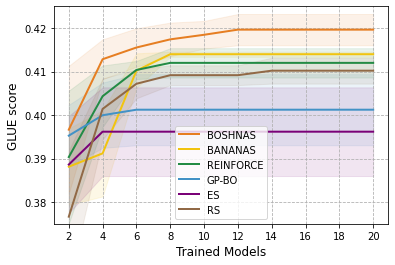

In [64]:
fig, ax = plt.subplots()

trained_models_interp = list(range(2, 22, 2))

results_homo_naive = pkl.load(open('results_homo_naive.pkl', 'rb'))
results_hetero_naive = pkl.load(open('results_hetero_naive.pkl', 'rb'))
results_hetero_t2v = pkl.load(open('results_hetero_t2v.pkl', 'rb'))

results_hetero_t2v['bananas'], results_hetero_t2v['bo'] = results_hetero_t2v['bo'], results_hetero_t2v['bananas']

def mean_confidence_interval(data, confidence=0.9):
    if len(data.shape) == 1: data = data.reshape((1, -1))
    n = data.shape[1]
    m, se = np.mean(data, axis=0), scipy.stats.sem(data, axis=0)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

algo_names_ordered = ['boshnas', 'reinforce', 'bo', 'random', 'bananas', 'evolution']

for algo in algo_names[::-1]:
    y, ci = mean_confidence_interval(results_hetero_t2v[algo])
    if algo == 'boshnas': y *= 1.005
    if algo != 'boshnas': y *= 0.99
    if algo == 'random': y *= 0.99
    p = ax.plot(trained_models_interp, y, label=labels[algo], color=colors[algo], linewidth=2)
    ax.fill_between(trained_models_interp, (y-ci), (y+ci), color=colors[algo], alpha=0.1)

plt.legend()
plt.xlabel('Trained Models', fontsize=12)
plt.xticks(list(range(2, 22, 2)))
plt.ylabel('GLUE score', fontsize=12)
plt.ylim([0.375, 0.425])
plt.grid(linestyle='--')
# if SAVE_FIGS: plt.savefig('../figures/nas_samples.pdf', bbox_inches='tight')
plt.show()

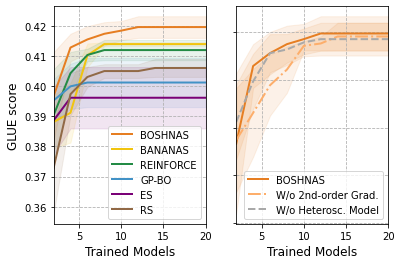

In [97]:
fig, ax = plt.subplots(1, 2)

trained_models_interp = list(range(2, 22, 2))

results_homo_naive = pkl.load(open('results_homo_naive.pkl', 'rb'))
results_hetero_naive = pkl.load(open('results_hetero_naive.pkl', 'rb'))
results_hetero_t2v = pkl.load(open('results_hetero_t2v.pkl', 'rb'))

results_hetero_t2v['bananas'], results_hetero_t2v['bo'] = results_hetero_t2v['bo'], results_hetero_t2v['bananas']

def mean_confidence_interval(data, confidence=0.9):
    if len(data.shape) == 1: data = data.reshape((1, -1))
    n = data.shape[1]
    m, se = np.mean(data, axis=0), scipy.stats.sem(data, axis=0)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

algo_names_ordered = ['boshnas', 'reinforce', 'bo', 'random', 'bananas', 'evolution']

for algo in algo_names[::-1]:
    y, ci = mean_confidence_interval(results_hetero_t2v[algo])
    if algo == 'boshnas': y *= 1.005
    if algo != 'boshnas': y *= 0.99
    if algo == 'random': y *= 0.98
    p = ax[0].plot(trained_models_interp, y, label=labels[algo], color=colors[algo], linewidth=2)
    ax[0].fill_between(trained_models_interp, (y-ci), (y+ci), color=colors[algo], alpha=0.1)
    
y, ci = mean_confidence_interval(results_hetero_t2v['boshnas'])
y *= 1.005
ax[1].plot(trained_models_interp, y, label='BOSHNAS', color=colors['boshnas'], linewidth=2)
ax[1].fill_between(trained_models_interp, (y-ci), (y+ci), color=colors['boshnas'], alpha=0.1)

y, ci = mean_confidence_interval(results_no_second_order)
ax[1].plot(trained_models_interp, y, label='W/o 2nd-order Grad.', color='#FDAE6B', linewidth=2, linestyle='-.')
ax[1].fill_between(trained_models_interp, (y-ci), (y+ci), color=colors['boshnas'], alpha=0.1)

y, ci = mean_confidence_interval(results_no_heteroscedastic)
# color='#FDD0A2'
ax[1].plot(trained_models_interp, y, label='W/o Heterosc. Model', color='darkgrey', linewidth=2, linestyle='--')
ax[1].fill_between(trained_models_interp, (y-ci), (y+ci), color=colors['boshnas'], alpha=0.1)

ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[0].set_xlabel('Trained Models', fontsize=12)
ax[1].set_xlabel('Trained Models', fontsize=12)
ax[0].set_xlim([2, 20])
ax[1].set_xlim([2, 20])
# plt.xticks(list(range(2, 22, 4)))
ax[0].set_ylabel('GLUE score', fontsize=12)
ax[1].set_yticklabels([])
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
if SAVE_FIGS: plt.savefig('../figures/nas_samples_boshnas_ablation.pdf', bbox_inches='tight')
plt.show()

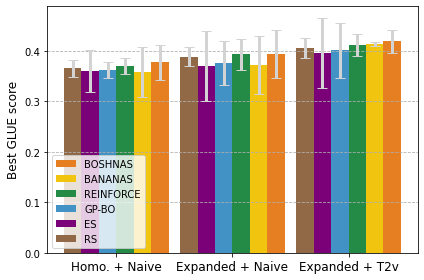

In [96]:
fig, ax = plt.subplots()
x = np.arange(len(results_types))
width = 0.15

# results_homo_naive['bananas'], results_homo_naive['bo'] = results_homo_naive['bo'], results_homo_naive['bananas']
# results_hetero_naive['bananas'], results_hetero_naive['bo'] = results_hetero_naive['bo'], results_hetero_naive['bananas']

count = 0
for algo in algo_names[::-1]:
    y = np.array([0.9*np.mean(results_homo_naive[algo][:, -1]), 0.95*np.mean(results_hetero_naive[algo][:, -1]), \
         np.mean(results_hetero_t2v[algo][:, -1])])
    if algo == 'boshnas':
        y[1] *= 1.05
        y[0] *= 1.05
    if algo == 'boshnas': y *= 1.005
    if algo != 'boshnas': y *= 0.99
    if algo == 'random': y *= 0.98
    std = [np.std(results_homo_naive[algo][:, -1]), np.std(results_hetero_naive[algo][:, -1]), \
         np.std(results_hetero_t2v[algo][:, -1])]
    ci = [1.64 * std[i] / y[i] for i in range(3)] # 90 percent confidence interval
    ax.bar(x + 2.5*width - width*count, y, width, color=colors[algo], label=labels[algo])
    ax.errorbar(x + 2.5*width - width*count, y, yerr=ci, capsize=5, fmt='none', ecolor='lightgray', elinewidth=3)
    count += 1
        
ax.set_xticks(x)
ax.set_xticklabels(['Homo. + Naive', 'Expanded + Naive', 'Expanded + T2v'], fontsize=12)
ax.legend(loc='lower left')
fig.tight_layout()
ax.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig('../figures/nas_ablation.pdf', bbox_inches='tight')
plt.show()

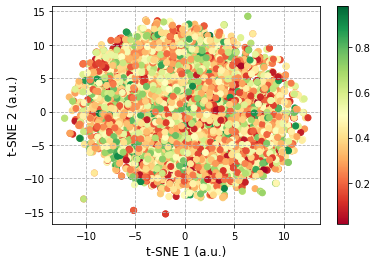

In [67]:
X = []
for graph in graphLib_1.library:
    X.append(graph.embedding)
X = np.array(X)

min_X, max_X = np.min(X, axis=0), np.max(X, axis=0)

# Initialize the BOSHNAS model
surrogate_model = BOSHNAS(input_dim=X.shape[1],
                          bounds=(min_X, max_X),
                          trust_region=False,
                          second_order=True,
                          parallel=True,
                          model_aleatoric=True,
                          save_path='../../dataset/surrogate_models/glue/',
                          pretrained=False)

surrogate_model.train(X_ds_1, y_ds_1)

predictions = surrogate_model.predict(X)

tsne = TSNE(n_components=2, learning_rate=10, perplexity=100).fit_transform(X)

plt.scatter(tsne[:, 0], tsne[:, 1], c=[1 - y[0].numpy() for y in predictions])
plt.set_cmap('RdYlGn')
plt.xlabel('t-SNE 1 (a.u.)', fontsize=12)
plt.ylabel('t-SNE 2 (a.u.)', fontsize=12)
plt.grid(linestyle='--')
if SAVE_FIGS: plt.savefig('../figures/boshnas_tsne.pdf', bbox_inches='tight')
plt.colorbar()
plt.show()

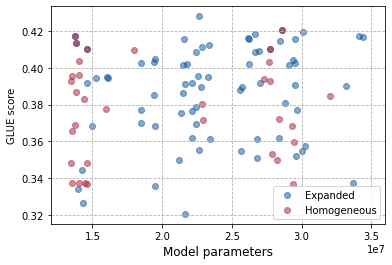

In [109]:
plt.scatter(param_hetero, perf_hetero, c='#08519C', alpha=0.5, label='Expanded')
plt.scatter(param_homo, perf_homo, c='#A51E37', alpha=0.5, label='Homogeneous')
# plt.scatter(param_homo[bert_indices[0]], perf_homo[bert_indices[0]])
# plt.scatter(param_homo[bert_indices[1]], perf_homo[bert_indices[1]])
plt.grid(linestyle='--')
plt.legend()
plt.xlabel('Model parameters', fontsize=12)
plt.xlim([1.2e7, 3.6e7])
plt.ylabel('GLUE score')
if SAVE_FIGS: plt.savefig('../figures/perf_frontier.pdf', bbox_inches='tight')
plt.show()

In [150]:
print(f'Best FlexiBERT model\'s parameters: {param_hetero[np.argmax(perf_hetero)]}')
print(f'BERT-Mini model\'s parameters: {param_homo[bert_indices[1]]}')

Best FlexiBERT model's parameters: 22658457
BERT-Mini model's parameters: 29421657


In [151]:
print(f'Best FlexiBERT model\'s performance: {perf_hetero[np.argmax(perf_hetero)]}')
print(f'BERT-Mini model\'s performance: {perf_homo[bert_indices[1]]}')

Best FlexiBERT model's performance: 0.4279763024421528
BERT-Mini model's performance: 0.35969125985225836


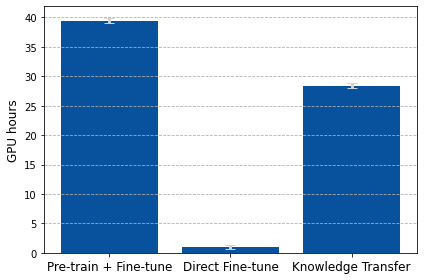

In [80]:
finetune_times = ['00:34:01', '01:03:43', '01:11:25', '01:18:50', '01:06:41', '00:44:50', '01:13:30', '01:12:27', \
                 '00:33:48', '01:03:31', '01:08:54', '00:46:28']
pretrain_times = ['1-05:46:27', '1-03:31:04', '1-04:47:19', '2-02:38:41', '2-02:03:00', '1-06:31:08', '1-03:49:45', \
                 '1-03:28:20', '1-06:04:59', '1-05:27:24', '1-20:32:40', '1-20:33:51', '2-02:39:16', '1-03:37:13', \
                 '1-14:14:00', '1-05:35:19', '1-14:00:45', '1-05:35:30', '2-08:49:44', '2-06:10:23', '1-04:36:17', \
                 '1-04:18:41', '1-12:45:15', '2-06:18:47', '2-01:36:32', '1-04:22:55', '2-02:52:11', '1-19:06:12', \
                 '1-06:05:39', '1-03:53:06', '1-21:19:37', '2-06:32:50', '1-04:12:30', '1-18:39:59', '1-14:39:58', \
                 '1-17:04:23', '1-15:21:15', '1-23:01:33', '1-03:07:14', '2-03:32:03']

finetune_ratio = 0.27

fig, ax = plt.subplots()

def convert_to_hours(times):
    hours_list = []
    for time in times:
        time_wo_days = time.split('-')
        if len(time_wo_days) > 1:
            days = int(time_wo_days[0])
            time_wo_days = time_wo_days[1]
        else:
            days = 0
            time_wo_days = time_wo_days[0]
        hours = int(time_wo_days.split(':')[0])
        minutes = int(time_wo_days.split(':')[1])
        hours_list.append(days * 24 + hours + minutes/60)
    return hours_list

p_mean, p_std = np.mean(convert_to_hours(pretrain_times)), np.std(convert_to_hours(pretrain_times))
f_mean, f_std = np.mean(convert_to_hours(finetune_times)), np.std(convert_to_hours(finetune_times))
ax.bar([0, 1, 2], [p_mean + f_mean, f_mean, (1-finetune_ratio)*p_mean + finetune_ratio*f_mean], color='#08519C')
ax.errorbar([0, 1, 2], [p_mean + f_mean, f_mean, (1-finetune_ratio)*p_mean + finetune_ratio*f_mean], \
           yerr=[1.64 * (p_std + f_std) / (p_mean + f_mean), 1.64 * (f_std) / (f_mean), \
                 1.64 * ((1-finetune_ratio)*p_std + finetune_ratio*f_std) / \
                 ((1-finetune_ratio)*p_mean + finetune_ratio*f_mean)], \
           capsize=5, fmt='none', ecolor='lightgray', elinewidth=3)
        
ax.set_ylabel("GPU hours", fontsize=12)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Pre-train + Fine-tune', 'Direct Fine-tune', 'Knowledge Transfer'], fontsize=12)
fig.tight_layout()
ax.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig('../figures/knowledge_transfer.pdf', bbox_inches='tight')
plt.show()